# The German Traffic Sign Recognition Benchmark

In [72]:
# importing the required packages

import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
import cv2
import imutils
from PIL import Image
from skimage import exposure, feature, transform
%matplotlib inline

# classification required packages

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Helper Functions

In [4]:
# helper functions 

# function for reading the images
# arguments: path to the traffic sign data, for example '../../GTSRB/train/Final_Training/Images/'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example '../dataset/GTSRB/train/Final_Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def get_csv(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.csv')]


def showimg_n_hog(grayimg,hogImage):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()
    
# Functions for testimages    
testpath="../dataset/GTSRB/test/Final_Test/Images/"
def loadtestimages_from_path(testpath):
    print("[INFO] reading all test images from directory\n")
    gtFile = get_csv(testpath)
    filename = gtFile[0]
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=';', quoting=csv.QUOTE_NONE)
    reader.next()
    testfiles = list(reader)
    timg = []
    testimg = []
#     tlbl = []
    for i in testfiles:
    #     print (i[0],i[-1])
        fname = os.path.join(testpath,i[0])
        timg.append(fname)
        tim = plt.imread(fname)
        testimg.append(tim)
#         label = i[-1]
#         tlbl.append(label)
    np.save("Image_n_Labels/testimagenames.npy",timg)
    np.save("Image_n_Labels/testimages.npy",testimg)
#     np.save("Image_n_Labels/testimagelabels.npy",tlbl)
    return timg,testimg
    
def loadtestimages_from_npy():
    print("[INFO] loading from .npy\n")
    timg = np.load("Image_n_Labels/testimagenames.npy")
    testimg = np.load("Image_n_Labels/testimages.npy")
#     tlbl = np.load("Image_n_Labels/testimagelabels.npy")
    return timg,testimg

## load training images

In [61]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    X = np.load("Image_n_Labels/trainImages.npy")
    y = np.load("Image_n_Labels/trainLabels.npy")
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns('../dataset/GTSRB/train/Final_Training/Images/')
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("[INFO] training labels saved to Image_n_Labels/trainingLabels.npy for further use")

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 39209 
Number of Labels 39209


## load test images

In [7]:
if (os.path.isfile("Image_n_Labels/testimagenames.npy") &  os.path.isfile("Image_n_Labels/testimages.npy")):
    timg,testimg = loadtestimages_from_npy()
else:
    timg,testimg = loadtestimages_from_path(testpath)

There are total 12630 test images availabe
Example ../dataset/GTSRB/test/Final_Test/Images/12629.ppm


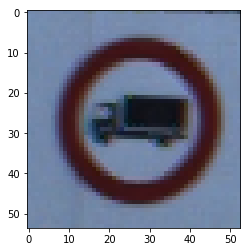

In [9]:
print("There are total {} test images availabe".format(len(timg)))
print("Example {}".format(timg[12629]))
plt.imshow(plt.imread(timg[0]))

In [10]:
y.astype("float")

array([  0.,   0.,   0., ...,  42.,  42.,  42.])

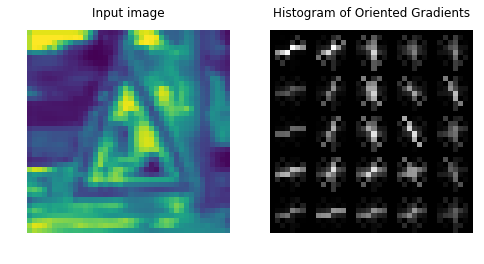

576


In [11]:
# simple test on single image for HoG features
n = np.random.randint(0,len(X))
i1 = X[n]
grayim = rgb2gray(i1)
gI1 = transform.resize(grayim,(40,40))
# gI2 = cv2.resize(grayim, (40, 40), interpolation = cv2.INTER_CUBIC)
(H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(8,8),
    cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

showimg_n_hog(gI1, hogImage)
print(len(H))

## Extract HoG features over all training images 

In [12]:
if os.path.isfile("HoGFeatures/HoGfeatures.npy") & os.path.isfile("HoGFeatures/HoGvisualize.npy") :
    print("loading from file ... ")
    hogfeat = np.load("HoGFeatures/HoGfeatures.npy")
    hogviz = np.load("HoGFeatures/HoGvisualize.npy")
    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz")
else:
    print("HoGfeatures.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
#         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize.npy", Hviz)
    print("HoGfeatures.npy are saved")  
    print("HoGvisualize.npy are saved")

loading from file ... 
HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat
HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz


## Extract HoG features over all testing images 

In [13]:
if os.path.isfile("HoGFeatures/HoGfeatures_test.npy") & os.path.isfile("HoGFeatures/HoGvisualize_test.npy") :
    hogfeat_test = np.load("HoGFeatures/HoGfeatures_test.npy")
    hogviz_test = np.load("HoGFeatures/HoGvisualize_test.npy")
    
    print("HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat_test")
    print("HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test")
else:
    print("HoGfeatures_test.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
    #         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures_test.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize_test.npy", Hviz)
    print("HoGfeatures_test.npy are saved")  
    print("HoGvisualize_test.npy are saved")

HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat_test
HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test


## converting datatype to float: training data

In [50]:
Xhog = np.array(hogfeat).astype("float")
y = y.astype("float")
print(Xhog.shape,y.shape)
print(np.unique(y))

((39209, 2916), (39209,))
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.]


## converting datatype to float: test data

In [51]:
X_t = np.array(hogfeat_test).astype("float")
print(X_t.shape)

(12630, 2916)


In [52]:
X_hog = pd.DataFrame(Xhog)

In [53]:
X_hog.head()

,0,1,2,3,4,5,6,7,8,9,...,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915
0,0.072230,0.033674,0.014052,0.012905,0.008588,0.0,0.0,0.000000,0.014921,0.087632,...,0.000000,0.050807,0.022688,0.039415,0.083773,0.062538,0.029324,0.000000,0.050438,0.000000
1,0.032179,0.000000,0.009637,0.013536,0.000000,0.0,0.0,0.010108,0.052713,0.075905,...,0.120012,0.089115,0.026171,0.012772,0.024310,0.087584,0.000000,0.005514,0.034753,0.040569
2,0.121812,0.031105,0.039984,0.000000,0.000000,0.0,0.0,0.000000,0.012812,0.100121,...,0.131397,0.049028,0.000000,0.000000,0.000960,0.058873,0.000000,0.030014,0.066235,0.000000
3,0.094488,0.131136,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.133118,...,0.129733,0.038213,0.000000,0.000000,0.014868,0.025527,0.000000,0.027597,0.032608,0.012159
4,0.039229,0.117052,0.009980,0.000000,0.000601,0.0,0.0,0.000000,0.011472,0.058563,...,0.051272,0.068669,0.020195,0.000000,0.040250,0.028077,0.000000,0.000000,0.050481,0.032100


In [54]:
Xt_hog = pd.DataFrame(X_t)
Xt_hog.tail()


,0,1,2,3,4,5,6,7,8,9,...,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915
12625,0.077456,0.021332,0.077131,0.053629,0.086382,0.000000,0.000000,0.000000,0.003836,0.069898,...,0.030939,0.122161,0.000000,0.035191,0.055457,0.035819,0.040360,0.114481,0.013713,0.012215
12626,0.039531,0.012652,0.157713,0.020080,0.032364,0.000000,0.000000,0.000960,0.000000,0.125118,...,0.000000,0.035144,0.025385,0.006044,0.012795,0.028675,0.010273,0.000000,0.000000,0.004640
12627,0.028590,0.018664,0.065121,0.024937,0.130718,0.000000,0.000000,0.028223,0.035795,0.015608,...,0.021922,0.092965,0.000000,0.035935,0.000000,0.033950,0.056011,0.000000,0.010660,0.064340
12628,0.027729,0.002800,0.000000,0.000000,0.043393,0.034292,0.018724,0.017540,0.000000,0.064669,...,0.020043,0.092382,0.000000,0.009313,0.000000,0.016396,0.000000,0.006640,0.053852,0.011477
12629,0.057895,0.012640,0.000000,0.023053,0.053999,0.016823,0.000000,0.025690,0.000000,0.088298,...,0.018421,0.016075,0.000000,0.044859,0.000000,0.102885,0.016367,0.043738,0.018543,0.000000


In [55]:
for i in range(0,len(np.unique(y))):
    yi = np.where(y==i)
#     print("label: {}  \n indices: {} ".format(i,yi))

In [56]:
features = Xhog
labels = y
Xtest = X_t

# take the  data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(features,
    labels, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels,
    test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 26465
validation data points: 2941
testing data points: 9803


## Multi-layer Perceptron 

In [57]:
# MLP
if os.path.isfile("clf/clf_mlp_hog.pkl"):
    print("[INFO] loading classifier: MLP =200 trained on HoG features...")
    mlp= joblib.load("clf/clf_mlp_hog.pkl")
    print("[INFO] Classifer is loaded as instance ::mlp::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \MLP = 200")
    mlp = MLPClassifier(hidden_layer_sizes=(200,))
    mlp.fit(trainData,trainLabels)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(mlp, 'clf/clf_mlp_hog.pkl') 
    print("[INFO] Classifier Saved")


[INFO] loading classifier: MLP =200 trained on HoG features...
[INFO] Classifer is loaded as instance ::mlp::


In [58]:
print("accuracy on training data: {}".format(mlp.score(trainData,trainLabels)))

accuracy on training data: 1.0


In [59]:
print("accuracy on test data: {}".format(mlp.score(testData,testLabels)))

accuracy on test data: 0.975925737019


In [60]:
print("accuracy on validation data: {}".format(mlp.score(valData,valLabels)))

accuracy on validation data: 0.973478408705


### cross validation accuracy

In [39]:
cv_score = cross_val_score(mlp,testData,testLabels,cv=5)
print("mean cross-validation score: {}".format(np.mean(cv_score)))

mean cross-validation score: 0.95877682288


In [32]:
mlp.predict(testData[8000])

/home/shravankumar/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 25.])

In [33]:
y_pred = mlp.predict(Xtest)

In [34]:
y_pred

array([ 16.,   1.,  38., ...,   3.,   7.,  10.])

In [40]:
import csv
with open('submission.csv', "wb") as csv_file:
        writer = csv.writer(csv_file, delimiter=';')
        for line in zip(timg,y_pred):
            writer.writerow(line)

### final classification report

In [44]:
predictions = mlp.predict(testData)
 
# show a final classification report demonstrating the accuracy of the classifier
print("EVALUATION ON TESTING DATA")
print(classification_report(testLabels, predictions))

EVALUATION ON TESTING DATA
             precision    recall  f1-score   support

        0.0       0.98      0.95      0.97        44
        1.0       0.93      0.96      0.95       594
        2.0       0.94      0.90      0.92       560
        3.0       0.96      0.96      0.96       348
        4.0       0.98      0.98      0.98       529
        5.0       0.89      0.89      0.89       462
        6.0       1.00      0.99      0.99        81
        7.0       0.93      0.96      0.94       336
        8.0       0.96      0.94      0.95       385
        9.0       1.00      0.99      1.00       359
       10.0       0.99      0.99      0.99       461
       11.0       0.99      1.00      0.99       291
       12.0       0.99      1.00      1.00       548
       13.0       1.00      1.00      1.00       549
       14.0       0.99      0.99      0.99       197
       15.0       0.99      0.99      0.99       152
       16.0       1.00      1.00      1.00       108
       17.0       

### Testing on random images

In [76]:
def testing_on_data():
    n = np.random.randint(0, high=len(testLabels))
    test1 =X[n]
    t1_true = y[n]

    plt.imshow(test1)
    plt.show()    

    grayim = rgb2gray(test1)
    grayim = transform.resize(grayim,(40,40))

    (t1_feat, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
        cells_per_block=(2, 2), transform_sqrt=True, visualise=True)

    t1_feat.shape
    t1_predict = mlp.predict(t1_feat)
    print("==========")
    print("True :{}\npredicted:{}\n".format(t1_true,t1_predict[0]))
    # show the prediction
    print("I think that belongs to class: {}".format(t1_predict[0]))
    print("==========")
    font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 10)
    img = Image.fromarray(test1)
    draw = ImageDraw.Draw(img)
    draw.text((0,0), str(t1_predict), (0,255,0), font=font)
    draw = ImageDraw.Draw(img)
    plt.show(img) 

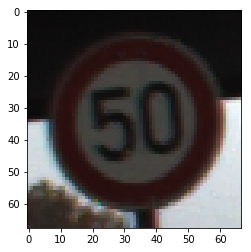

True :2
predicted:2.0

I think that belongs to class: 2.0


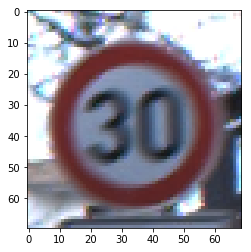

True :1
predicted:1.0

I think that belongs to class: 1.0


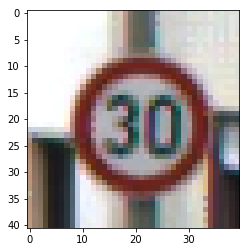

True :1
predicted:1.0

I think that belongs to class: 1.0


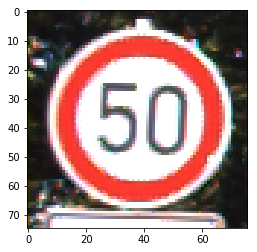

True :2
predicted:2.0

I think that belongs to class: 2.0


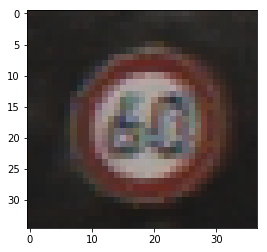

True :3
predicted:3.0

I think that belongs to class: 3.0


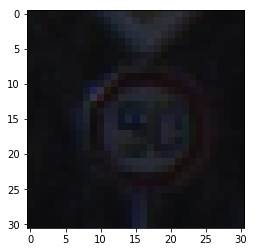

True :2
predicted:2.0

I think that belongs to class: 2.0


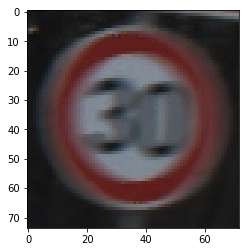

True :1
predicted:5.0

I think that belongs to class: 5.0


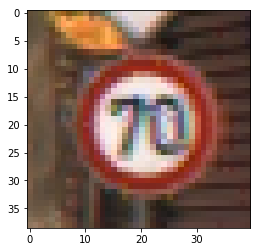

True :4
predicted:4.0

I think that belongs to class: 4.0


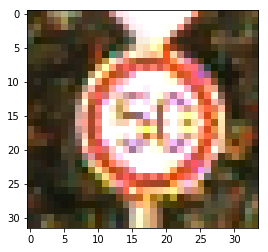

True :2
predicted:2.0

I think that belongs to class: 2.0


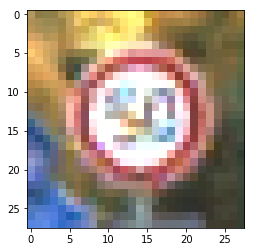

True :2
predicted:2.0

I think that belongs to class: 2.0


In [77]:
for i in range(10):
    testing_on_data()